<h3> NBA 5 year careeer prediction using XBoost Classifier

In [1]:
import pandas as pd
import numpy as np

<h4> 1. Load processed sets

<h5> Loading scaled training, validation and test sets from data_prep step saved on the data/processed folder saving them into X_train, X_val, y_train, y_val, X_test, X_test_ID variables

In [2]:
#Load Test and validation sets using custom function load_sets
from src.data.sets import load_sets

In [3]:
X_train, X_val, y_train, y_val, X_test, X_test_ID = load_sets()

<h4> 2. Import XGBoost

<h5> Importing and fitting XGBoost Classifier specifying early_stopping_rounds=10 to stop the model after 10 iterations without improving in the predictions, n_estimators=200 and evaluation metric=aucpr to meassure the accuracy of the model vs the validation set

In [4]:
import xgboost as xgb

In [5]:
# calculating weights for unbalanced data 
sum_wpos = len([item for item in y_train if item==1 ])
sum_wneg = len([item for item in y_train if item==0 ])
sum_wneg/sum_wpos

0.23635153129161118

<h4> 2.1 Analyse features importance in random forest model with current training sets

In [6]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', 
                              scale_pos_weight= sum_wneg/sum_wpos,
                              n_estimators=200, seed=42)

In [7]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(xgb_model
                     # , threshold = "0.98*mean"
                     )
sel.fit(X_train, y_train)

SelectFromModel(estimator=XGBClassifier(base_score=None, booster='gbtree',
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=None, gpu_id=None,
                                        grow_policy=None, importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=200, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=None, ...))

<h4> 2.2 Finding the most relevant features in making predictions

<h5> After the model has been fitted, we use get.support to find out which features are most relevant in the predictions

In [8]:
columns = sel.get_support()
columns = columns.tolist()

<h5> As column importance is given in order of appearance on the scaled set, importing column names saved in data_prep for easy visualization and identification will be performed

<h5> Importing predictor column names and combining with relevant columns to find out the best feature predictors

In [9]:
predictors  = pd.read_csv('../data/interim/predictor_names.csv')

In [10]:
predictors_df = predictors.copy()

In [11]:
predictors = predictors['names'].tolist()

In [12]:
predictors_df['Relevant_Feature'] = columns

In [13]:
predictors_df

,names,Relevant_Feature
0,GP,True
1,3P Made,False
2,FTM,False
3,STL,False
4,BLK,True
5,3P_per_GP,False
6,GP_cluster,False
7,Stl_per_GP,False


In [14]:
predictors_df.loc[predictors_df['Relevant_Feature'] == 1]

,names,Relevant_Feature
0,GP,True
4,BLK,True


<h5> <b>CONCLUSION ON PREDICTORS: </b> Based on the rebalanced training set from data_prep, 6 features are the most relevant predictors. Therefore new data prep will be generated for usage of these columns within the model

<h4> 2.3 New data prep to be performed and data sets saved in the ../data/interim folder

<h5> 2.3.1 Get a list of column names to be removed from data set

In [15]:
columns_to_remove_df = predictors_df.loc[predictors_df['Relevant_Feature'] == 0]

In [16]:
columns_to_remove = columns_to_remove_df.pop("names")

In [17]:
columns_to_remove_list = columns_to_remove.values.tolist()

<h5> 2.3.2 Read csvs and remove unwanted columns

In [18]:
# Remove columns with low predictor power training set

In [19]:
#df_cleaned.drop(columns=columns_to_remove_list, axis=1, inplace=True)

In [20]:
#Replace negatives with 0s as there can't be negative values

In [21]:
#Remove unwanted columns based on previous experiments

<h5> Finally, all cleaned and transfor sets will be saved in the data/interim folder using a custom function saved in the src folder

In [22]:
#from src.data.sets import save_sets_interim

In [23]:
#save_sets_interim(X_train, X_val, y_train, y_val, X_test, X_test_ID)

<h4> 3 Train XGB Classifier with new calculated training sets

<h5> Next up, the XGB classifier will be imported and trained with the new training set and saved into the models folder

In [24]:
xgb_model.fit(X_train, y_train , early_stopping_rounds=10, 
              eval_metric='aucpr', eval_set=[(X_val,y_val)])

[0]	validation_0-aucpr:0.90824
[1]	validation_0-aucpr:0.91145
[2]	validation_0-aucpr:0.91191
[3]	validation_0-aucpr:0.90997
[4]	validation_0-aucpr:0.90942
[5]	validation_0-aucpr:0.90760
[6]	validation_0-aucpr:0.90710
[7]	validation_0-aucpr:0.90467
[8]	validation_0-aucpr:0.90658
[9]	validation_0-aucpr:0.90707
[10]	validation_0-aucpr:0.90630
[11]	validation_0-aucpr:0.90578


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

<h5> After the model has been fitted, it will be saved in the models folder in case it needs to be re-called on a later process

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
#Save model in the models folder
from joblib import dump
dump(xgb_model, '../models/XGBoost3.joblib')

['../models/XGBoost3.joblib']

<h4> 3.1 Generate predictions for training and validation sets in order to compare accuracy vs Baseline

<h5> The fitted model will be used to predict the validation set and accuracy willl be calculated to compare vs the baseline

In [27]:
y_val_preds = xgb_model.predict(X_val)

In [28]:
y_trainpreds = xgb_model.predict(X_train)

In [29]:
accuracy = accuracy_score(y_val, y_val_preds)
accuracy

0.62125

<h4> 3.2 Calculate mse and mae to assess fiting accuracy for the training and validation sets

In [30]:
#Get error/score metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [31]:
print(mse(y_train, y_trainpreds, squared=False))
print(mae(y_train, y_trainpreds))

0.522857536610136
0.27338000359001974


In [32]:
print(mse(y_val, y_val_preds, squared=False))
print(mae(y_val, y_val_preds))

0.6154266812545586
0.37875


In [33]:
xgb_model.score(X_train, y_train)

0.7266199964099802

In [34]:
xgb_model.score(X_val, y_val)

0.62125

<h4> 3 Analysis of the validation set

<h5> Analysis of the results will be done through a confusion matrix to gather insights as to where the accuracy/innacuracy exists in order to improve the model in future experiments

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

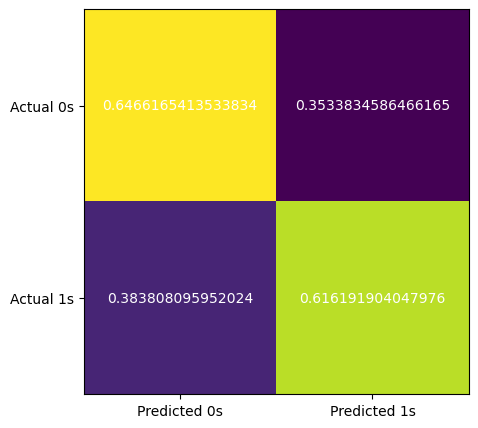

In [36]:
cm = confusion_matrix(y_val, y_val_preds , normalize='true'
                     )

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

<h4> 4 Generate predictions on the test set for Kaggle submission

<h5> The final step is to generate the prediction probabilities from the test set in order to evaluate the score from Kaggle via csv upload

In [37]:
#Analyse lines that are not predicted correctly

In [38]:
#Filter Predicted 1 actual 0

In [39]:
import joblib
scaler = joblib.load('../models/scaler3.joblib') 

In [40]:
X_val_scaled_back = scaler.inverse_transform(X_val)

In [41]:
X_val_scaled_back_df = pd.DataFrame(X_val_scaled_back, columns=predictors)

In [42]:
y_val_list = y_val.tolist()

In [43]:
X_val_re_built = X_val_scaled_back_df.copy()

In [44]:
X_val_re_built['y_val']=y_val_list

In [45]:
X_val_re_built['y_val_preds']=y_val_preds

In [46]:
#Filter observations for Actual=0 but prediction = 1

In [47]:
#True Negatives
X_val_true_neg = X_val_re_built[(X_val_re_built['y_val']==0)&(X_val_re_built['y_val_preds']==0)]
X_val_true_neg.describe()

,GP,3P Made,FTM,STL,BLK,3P_per_GP,GP_cluster,Stl_per_GP,y_val,y_val_preds
count,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.0,172.0
mean,45.296512,0.275581,0.751163,0.439535,0.146512,0.006263,0.662791,0.010261,0.0,0.0
std,13.097895,0.300267,0.533497,0.274567,0.182059,0.007392,0.474137,0.006664,0.0,0.0
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,37.000000,0.000000,0.400000,0.200000,0.000000,0.000000,0.000000,0.005240,0.0,0.0
50%,46.500000,0.200000,0.600000,0.400000,0.100000,0.004160,1.000000,0.009339,0.0,0.0
75%,54.000000,0.500000,1.000000,0.600000,0.225000,0.010104,1.000000,0.013239,0.0,0.0
max,80.000000,1.400000,2.900000,1.400000,1.200000,0.038462,1.000000,0.043750,0.0,0.0


In [48]:
#False Positive
X_val_false_pos = X_val_re_built[(X_val_re_built['y_val']==0)&(X_val_re_built['y_val_preds']==1)]
X_val_false_pos.describe()

,GP,3P Made,FTM,STL,BLK,3P_per_GP,GP_cluster,Stl_per_GP,y_val,y_val_preds
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.00000,94.000000,94.0,94.0
mean,66.787234,0.365957,1.381915,0.645745,0.379787,0.005713,0.12766,0.009970,0.0,1.0
std,11.601698,0.238523,0.698072,0.315092,0.834160,0.003805,0.33550,0.005572,0.0,0.0
min,46.000000,0.000000,0.200000,0.100000,0.000000,0.000000,0.00000,0.001613,0.0,1.0
25%,59.000000,0.200000,0.825000,0.400000,0.100000,0.003092,0.00000,0.005831,0.0,1.0
50%,66.000000,0.400000,1.200000,0.600000,0.200000,0.005674,0.00000,0.009763,0.0,1.0
75%,76.000000,0.500000,1.800000,0.800000,0.400000,0.008466,0.00000,0.012452,0.0,1.0
max,93.000000,0.900000,4.200000,1.800000,7.800000,0.014516,1.00000,0.032609,0.0,1.0


In [49]:
# True Positives
X_val_true_pos = X_val_re_built[(X_val_re_built['y_val']==1)&(X_val_re_built['y_val_preds']==1)]
X_val_true_pos.describe()

,GP,3P Made,FTM,STL,BLK,3P_per_GP,GP_cluster,Stl_per_GP,y_val,y_val_preds
count,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.0,822.0
mean,73.038929,0.338564,1.783090,0.776277,0.442822,0.004673,0.049878,0.010615,1.0,1.0
std,13.422886,0.308482,0.936052,0.431590,0.975468,0.004291,0.217826,0.005564,0.0,0.0
min,23.000000,0.000000,0.100000,0.100000,0.000000,0.000000,0.000000,0.001299,1.0,1.0
25%,64.000000,0.000000,1.100000,0.500000,0.200000,0.000000,0.000000,0.006667,1.0,1.0
50%,73.000000,0.300000,1.700000,0.700000,0.300000,0.004218,0.000000,0.009524,1.0,1.0
75%,82.000000,0.600000,2.300000,1.000000,0.500000,0.007344,0.000000,0.013622,1.0,1.0
max,115.000000,1.600000,7.000000,2.500000,18.900000,0.023188,1.000000,0.037313,1.0,1.0


In [50]:
# False Negative
X_val_false_neg = X_val_re_built[(X_val_re_built['y_val']==1)&(X_val_re_built['y_val_preds']==0)]
X_val_false_neg.describe()

,GP,3P Made,FTM,STL,BLK,3P_per_GP,GP_cluster,Stl_per_GP,y_val,y_val_preds
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.0,512.0
mean,50.306641,0.303320,0.906250,0.512891,0.166797,0.006275,0.531250,0.010321,1.0,0.0
std,11.214407,0.304321,0.559039,0.339664,0.191070,0.006651,0.499511,0.006569,0.0,0.0
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0
25%,44.000000,0.000000,0.500000,0.300000,0.000000,0.000000,0.000000,0.005634,1.0,0.0
50%,52.000000,0.200000,0.800000,0.400000,0.100000,0.004598,1.000000,0.008830,1.0,0.0
75%,59.000000,0.500000,1.200000,0.700000,0.300000,0.009877,1.000000,0.013208,1.0,0.0
max,81.000000,1.700000,3.200000,2.100000,1.900000,0.050000,1.000000,0.044444,1.0,0.0


In [51]:
y_test_preds = xgb_model.predict_proba(X_test)

In [52]:
#Create Data Frame for Doc printing
df =pd.DataFrame()

In [53]:
y_test_preds


array([[0.63438535, 0.36561468],
       [0.6029414 , 0.3970586 ],
       [0.30579507, 0.6942049 ],
       ...,
       [0.62627786, 0.37372214],
       [0.3015567 , 0.6984433 ],
       [0.51727307, 0.4827269 ]], dtype=float32)

In [54]:
target_prob = y_test_preds
target_prob = [item[1] for item in y_test_preds]

In [55]:
df['Id'] = X_test_ID
df['TARGET_5Yrs'] = target_prob

In [56]:
df.head()

,Id,TARGET_5Yrs
0,0,0.365615
1,1,0.397059
2,2,0.694205
3,3,0.682397
4,4,0.433060


In [57]:
#Saving predictions into csv
df.to_csv('../data/external/Kaggle_submission_XGBoost_smote_selected_cols.csv', index=False)